In [ ]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import seaborn as sns
import cebra
from cebra import CEBRA

from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels
from plotting import subplot_confusion_matrix
from constants import AUDIO_BLOCKS
from features.constants import Feature, MARKER_TO_FEATURE

data_dir = "../CleandDataV2/"
random.seed(33)

## Helper functions

In [ ]:
from features.psd import get_psd_by_channel, get_psd
from biomarkers import EEG_CHANEL_NAMES
from labels import get_raw_labels, get_label_means
from feature_extraction import EEG_BANDS
from resample.resample import (
    get_validation_indexes,
    upsample_by_attention,
    get_resampled_list_index,
    slice_data_by_seconds,
)


def get_psd_by_channel_band(block_data, channel_type: str, srate: int, feature):
    psd_data = []
    num_trials = block_data.shape[0]
    # loop through all trials: time -> frequency
    for t in range(num_trials):
        all_channel_psd = []
        for i, c in enumerate(EEG_CHANEL_NAMES):
            if not c.startswith(channel_type):
                continue

            psd = get_psd(block_data[t, i, :], srate, EEG_BANDS[feature])
            all_channel_psd.append(psd)

        all_channel_psd = np.concatenate(all_channel_psd)
        psd_data.append(all_channel_psd)

    return np.stack(psd_data, axis=0)


def get_features(block_data, marker, channel_type: str, srate: int, feature):
    if marker == "EEG":
        return get_psd_by_channel_band(block_data, channel_type, srate, feature)
    if feature == Feature.ECG_HF or feature == Feature.EGG_FILTERED:
        return block_data[:, 0, :]
    elif feature == Feature.ECG_LF or feature == Feature.EGG_PHASE:
        return block_data[:, 1, :]
    elif feature == Feature.ECG_LFHF or feature == Feature.EGG_AMPLITUDE:
        return block_data[:, 2, :]


def get_block_features(
    blocks, subject_data, marker, channel, feature, with_sliced: bool = False
):
    features = []

    for b in blocks:
        block_data = subject_data[b]
        if with_sliced:
            srate = block_data.get_srate(marker)
            sliced_data = slice_data_by_seconds(
                block_data.get_all_data()[marker], srate, 4
            )
            psd_data = get_features(sliced_data, marker, channel, srate, feature)
        else:
            psd_data = get_psd_by_channel(block_data, marker, channel, feature)

        features = np.vstack((psd_data, features)) if len(features) > 0 else psd_data

    return features


def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]


def get_channel_feature_to_data(subject_data, marker: str = "EEG"):
    sliced_channel_feature_to_data = {"A": {}, "B": {}, "C": {}, "D": {}}
    for c in sliced_channel_feature_to_data.keys():
        for f in EEG_BANDS.keys():
            raw_data = get_block_features(
                AUDIO_BLOCKS, subject_data, marker, c, f, True
            )
            sliced_channel_feature_to_data[c][f] = raw_data

    return sliced_channel_feature_to_data


def get_feature_to_data(subject_data, marker: str = "EEG"):
    if marker == "EEG":
        return get_channel_feature_to_data(subject_data, marker)

    sliced_feature_to_data = {marker: {f: {} for f in MARKER_TO_FEATURE[marker]}}
    for f in sliced_feature_to_data[marker].keys():
        raw_data = get_block_features(AUDIO_BLOCKS, subject_data, marker, "", f, True)
        sliced_feature_to_data[marker][f] = raw_data

    return sliced_feature_to_data

## Load data and process features

### Slicing

In [32]:
import os

marker = "EEG"
num_slice_per_trial = 5

# [2001, 2003, 2017, 2026, 2028, 2033,  2037, 2041]
subject_list = []
marker_features = []
valence_labels, arousal_labels, attention_labels = [], [], []
label_thresholds = []
for d in os.listdir(data_dir):
    if d != '2041' and d != '2003':
        continue
    
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subject_data = load_data_from_dir(dir_name)
    features = get_feature_to_data(subject_data, marker)
    vl, arl, atl = get_raw_labels(AUDIO_BLOCKS, subject_data, num_slice_per_trial)
    
    marker_features.append(features)
    subject_list.append(d)
    valence_labels.append(vl)
    arousal_labels.append(arl)
    attention_labels.append(atl)
    label_thresholds.append(get_label_means(subject_data))

Loading ../CleandDataV2/2041 data...
Loading ../CleandDataV2/2003 data...


In [40]:
IDX_MAP = {
    "hvha": 0,
    "hvla": 1,
    "nvha": 2,
    "nvla": 3,
    "lvha": "blue",
    "lvla": "steelblue",
}

cat_labels = []
for idx, (v_thred, a_thred) in enumerate(label_thresholds):
    vc = [ 'hv' if l > v_thred else 'nv' for l in valence_labels[idx]]
    ac = [ 'ha' if l > a_thred else 'la' for l in arousal_labels[idx]]
    vac = [ IDX_MAP[vc[i]+ac[i]] for i in range(len(vc))]
    cat_labels.append(vac)
len(cat_labels)

2

In [75]:
import pickle

# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    all_features = pickle.load(fp)
    print('Person dictionary')
all_features

Person dictionary


[{'A': {'DELTA': array([[2.59531868, 3.94020101, 1.00231205, ..., 2.10731467, 1.47987276,
           0.26444337],
          [1.67768418, 2.35648602, 1.24352772, ..., 1.30237506, 0.29558868,
           0.326291  ],
          [1.88444476, 2.33281992, 1.19932711, ..., 1.00220033, 1.03730859,
           0.78521715],
          ...,
          [3.27929862, 1.3645169 , 3.32405735, ..., 0.34566383, 0.3261214 ,
           0.6519467 ],
          [4.65262174, 1.71162187, 0.61113184, ..., 0.86408331, 1.0656262 ,
           1.17735381],
          [5.30536199, 3.69855819, 4.66532705, ..., 0.50540143, 0.70413658,
           1.11900623]]),
   'THETA': array([[1.29967115, 1.74151067, 1.09795038, ..., 0.17901736, 0.1085447 ,
           0.21044172],
          [1.16852328, 0.43972995, 1.21964541, ..., 0.81268703, 0.24453315,
           0.21605053],
          [0.82723763, 0.22773942, 0.79413623, ..., 0.550789  , 0.67941082,
           0.13373123],
          ...,
          [0.36554672, 0.36435646, 1.37188682

## Model Training

### Training utils

In [77]:
import ipywidgets as widgets
from plotting import plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score

# from importlib import reload
# import features.constants

# reload(features.constants)
from model.embedding import get_embeddings

# CEBRA AND PCA hyper-parameters
OUTPUT_DIM = 6
MAX_HIDDEN_UNITS = 256


def _train_test_split(data, labels, attention_labels, val_indexes: list = []):
    if len(val_indexes) == 0:
        val_indexes = get_validation_indexes()

    train_indexes = list(set(range(len(labels))) - set(val_indexes))
    resampled_list = get_resampled_list_index(train_indexes, attention_labels)

    train_labels = np.array(labels)[train_indexes][resampled_list]
    train_data = data[train_indexes][resampled_list]

    val_data = data[val_indexes]
    val_label = np.array(labels)[val_indexes]
    return train_data, train_labels, val_data, val_label


# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    output_dim,
    max_hidden_units,
):
    y_pred, all_embeddings = [], []
    for _, (train_data, train_labels, val_data, _) in enumerate(dataset):
        embedding, val_embedding = get_embeddings(
            train_data=train_data,
            val_data=val_data,
            train_labels=train_labels,
            use_pca=(method == "PCA"),
            out_dim=output_dim,
            num_hidden_units=max_hidden_units,
        )
        all_embeddings.append(embedding)
        # 4. Train the decoder on training embedding and labels
        # train_true_cat = get_label_category(train_labels, label_type)
        decoder = cebra.KNNDecoder()
        decoder.fit(embedding, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict(val_embedding)
        y_pred.append(prediction)

    return y_pred, all_embeddings


def get_all_spectral_features(
    feature_to_data: dict, val_indexes, attention_labels, labels
):
    all_spetral_psd = [feature_to_data[f] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return [
        _train_test_split(all_spetral_psd, labels, attention_labels, val_indexes[i])
        for i in range(len(val_indexes))
    ]


def get_all_channel_features(data: dict, val_indexes, attention_labels, labels):
    all_spetral_psd = []
    for _, feature_to_data in data.items():
        spetral_psd = [feature_to_data[f] for f in EEG_BANDS.keys()]
        all_spetral_psd.extend(spetral_psd)

    all_spetral_psd = np.hstack(all_spetral_psd)
    return [
        _train_test_split(all_spetral_psd, labels, attention_labels, val_indexes[i])
        for i in range(len(val_indexes))
    ]


def prepare_dataset(
    data,
    val_indexes,
    attention_labels,
    labels,
    has_all_spectral: bool = False,
    filtered_channel: str = "",
):
    if filtered_channel == "ALL":
        return {
            "ALL": {
                Feature.ALL_SPECTRAL: get_all_channel_features(
                    data, val_indexes, attention_labels, labels
                )
            }
        }

    dataset_dict = {k: {} for k in data.keys()}
    for channel, feature_to_data in data.items():
        if len(feature_to_data) == 0 or (
            channel != filtered_channel and len(filtered_channel) > 0
        ):
            continue

        if has_all_spectral:
            dataset_dict[channel][Feature.ALL_SPECTRAL] = get_all_spectral_features(
                feature_to_data, val_indexes, attention_labels, labels
            )
            continue

        for f, neural_data in feature_to_data.items():
            # Prepare the data
            dataset_dict[channel][f] = [
                _train_test_split(neural_data, labels, attention_labels, val_indexes[i])
                for i in range(len(val_indexes))
            ]
    return dataset_dict


def set_pane_axis(ax):
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.zaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])


def decode_marker_data(
    dataset_dict,
    label_type,
    method,
    plot_roc: bool = False,
    plot_embed: bool = False,
):
    f1_score_data = {k: {} for k in dataset_dict.keys()}
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if len(feature_to_data) == 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                val_labels for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                OUTPUT_DIM,
                MAX_HIDDEN_UNITS,
            )

            if plot_roc:
                plot_roc_curve(None, val_true_cat, method, label_type, channel, f)

            ac_scores = [
                accuracy_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]
            if plot_embed:
                max_score_index = np.array(ac_scores).argmax(axis=0)
                best_acc = round(ac_scores[max_score_index], 2)
                list_embedding_tuple.append(
                    (
                        f"{channel} {f} Acc:{best_acc}",
                        all_embeddings[max_score_index],
                        dataset[max_score_index][1],
                    )
                )

            accuracy[channel][f] = np.mean(ac_scores)

    if len(list_embedding_tuple) > 0:
        n_row, n_col = (2, 3) if len(list_embedding_tuple) == 6 else (1, 4)
        fig, axes = plt.subplots(
            nrows=n_row,
            sharey=True,
            ncols=n_col,
            figsize=(n_col * 5, n_row * 5),
            subplot_kw=dict(projection="3d"),
        )
        idx1, idx2, idx3 = (0, 1, 2)
        for idx, (title, embeddings, embedding_labels) in enumerate(
            list_embedding_tuple
        ):
            y = axes.flat[idx].scatter(
                embeddings[:, idx1],
                embeddings[:, idx2],
                embeddings[:, idx3],
                cmap="cool",
                c=embedding_labels,
                s=5,
                vmin=0,
                vmax=1,
            )
            axes.flat[idx].set_title(title)
            yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.arange(0, 4, 1))
            yc.ax.tick_params(labelsize=10)
            yc.ax.set_title("score", fontsize=10)
            set_pane_axis(axes.flat[idx])

        fig.suptitle(f"{method} - {label_type} Latents: (1,2,3)")

    return f1_score_data, accuracy

### Cross Validation

In [35]:
from resample.resample import get_consecutive_validation_indexes

n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        len(valence_labels[0]), len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

4 [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 180, 181, 182, 183, 184, 185, 186, 

### Get subjects summary

decoding subject... 2041
decoding subject... 2003


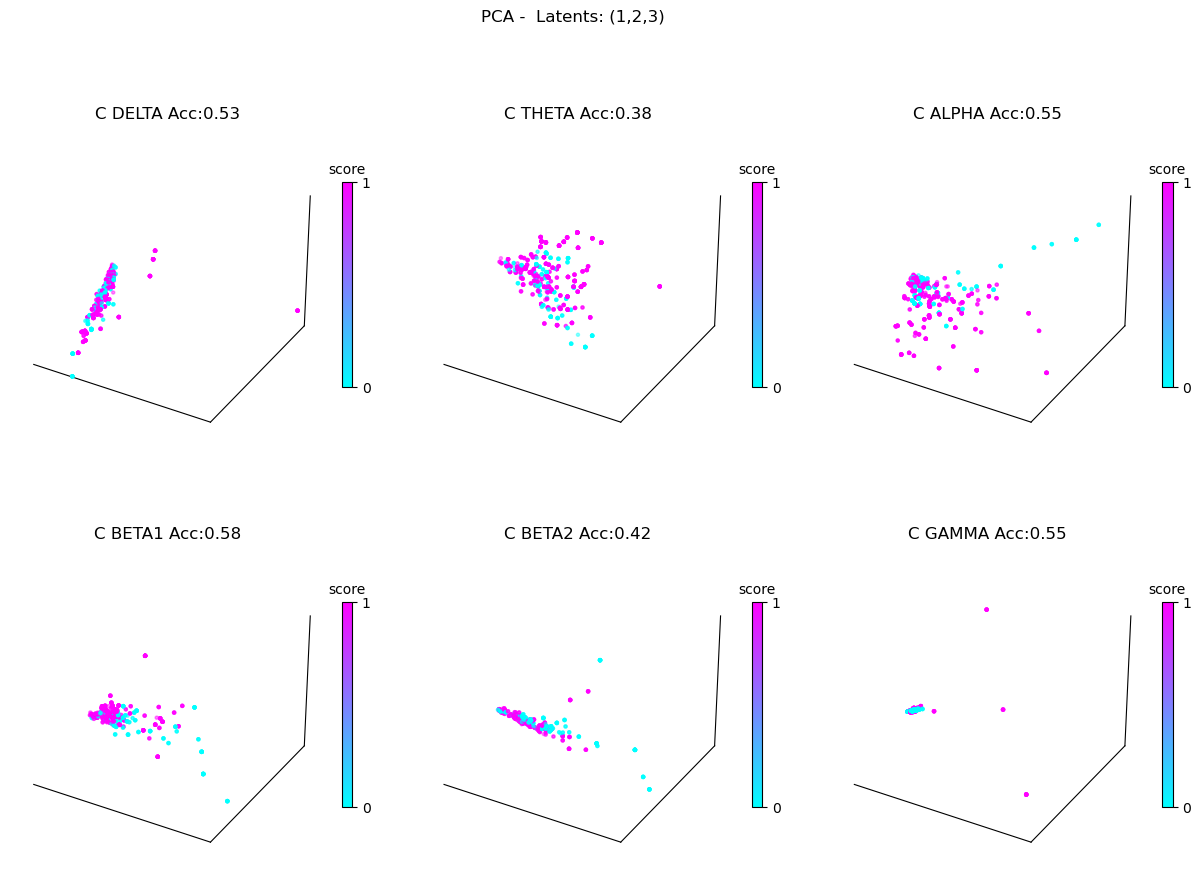

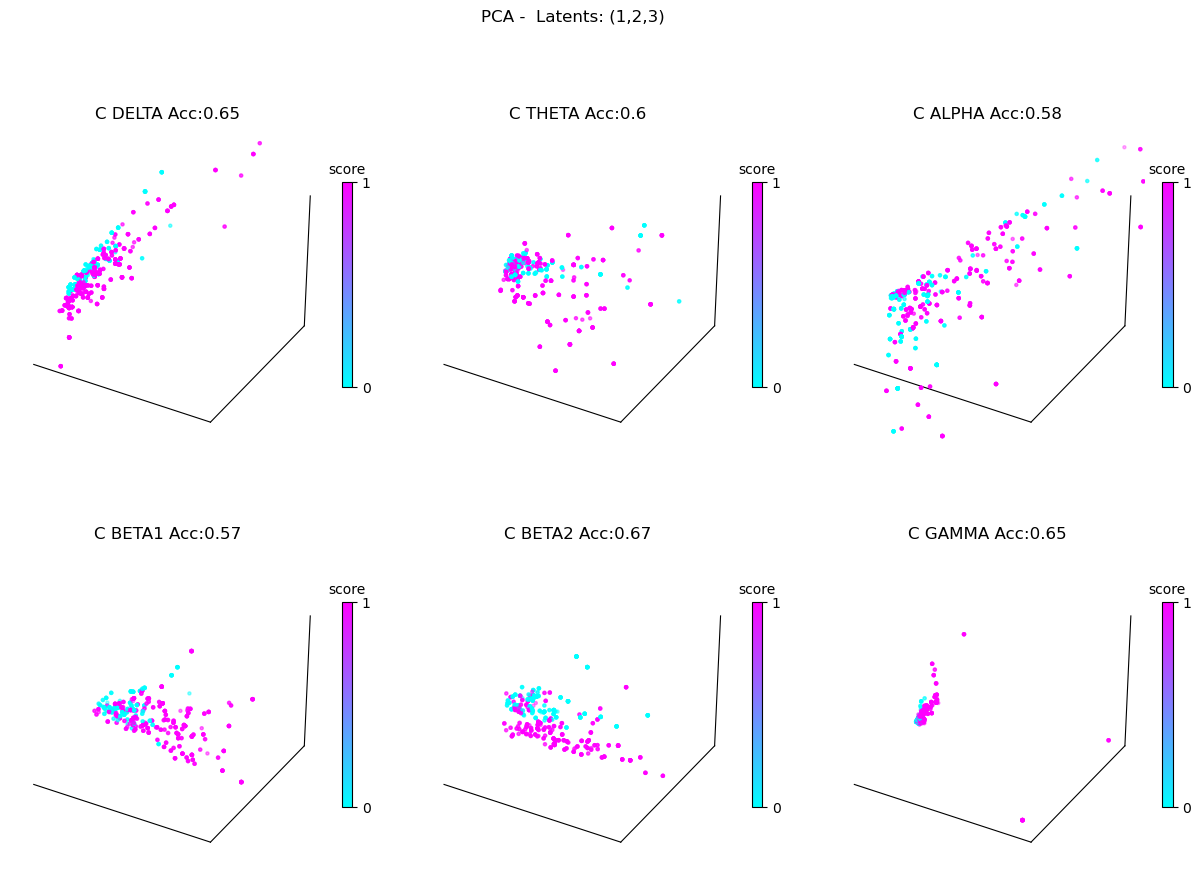

In [78]:
def get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker: str, filtered_channel: str
):
    if marker != "EEG":
        return list(dataset_dict[marker].keys()), [
            accuracy[marker][f] for f in all_feature_name
        ]

    if len(filtered_channel) == 0:
        all_feature_name = list(dataset_dict.keys())
        mean_scores = [accuracy[c][Feature.ALL_SPECTRAL] for c in all_feature_name]
    else:
        all_feature_name = list(dataset_dict[filtered_channel].keys())
        mean_scores = [accuracy[filtered_channel][f] for f in all_feature_name]

    return all_feature_name, mean_scores


subject_accuracy_summary = {
    "subject": [],
    "channel": [],
    "cv_mean_score": [],
}
filtered_channel = "C"

for idx in range(len(subject_list)):
    print('decoding subject...', subject_list[idx])

    v_thred, a_thred = label_thresholds[idx]
    labels = cat_labels[idx]
    dataset_dict = prepare_dataset(
        marker_features[idx],
        val_indexes,
        attention_labels[idx],
        labels,
        False,
        filtered_channel,
    )

    f1_score_data, accuracy = decode_marker_data(
        dataset_dict, '', "PCA", False, True
    )

    all_feature_name, mean_scores = get_feature_names_and_mean_scores(
        dataset_dict, accuracy, marker, filtered_channel
    )
    subject_accuracy_summary["subject"].extend(
        [subject_list[idx]] * len(all_feature_name)
    )
    subject_accuracy_summary["channel"].extend(all_feature_name)
    subject_accuracy_summary["cv_mean_score"].extend(mean_scores)

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary["subject"] = subject_accuracy_summary["subject"].astype(int)

In [53]:
subject_accuracy_summary["channel"] = subject_accuracy_summary["channel"].astype(str)
subject_accuracy_summary

,subject,channel,cv_mean_score
0,2041,Feature.DELTA,0.479167
1,2041,Feature.THETA,0.395833
2,2041,Feature.ALPHA,0.420833
3,2041,Feature.BETA1,0.441667
4,2041,Feature.BETA2,0.416667
5,2041,Feature.GAMMA,0.441667
6,2003,Feature.DELTA,0.587500
7,2003,Feature.THETA,0.333333
8,2003,Feature.ALPHA,0.570833
9,2003,Feature.BETA1,0.604167


/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


Text(0.5, 1.0, 'EEG C channel - PCA')

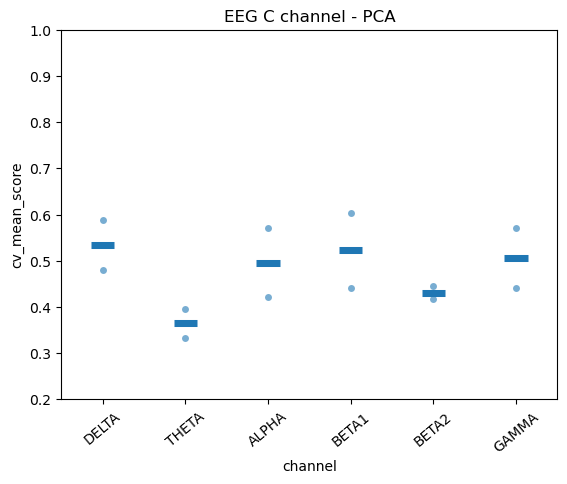

In [62]:
data = subject_accuracy_summary
title = "EEG C channel - PCA"  #
g = sns.swarmplot(
    data=data,
    x="channel",
    y="cv_mean_score",
    alpha=0.6,
    dodge=True,
    legend=False,
)
g.set_ylim((0.2, 1))

df_means = data.groupby(["channel"])["cv_mean_score"].agg("mean").reset_index()
pp = sns.pointplot(
    x="channel",
    y="cv_mean_score",
    data=df_means,
    dodge=0.6,
    linestyles="",
    errorbar=None,
    scale=2.5,
    markers="_",
    order=[
        "Feature.DELTA",
        "Feature.THETA",
        "Feature.ALPHA",
        "Feature.BETA1",
        "Feature.BETA2",
        "Feature.GAMMA",
    ],
)
pp.set_xticklabels(['DELTA', 'THETA', 'ALPHA', 'BETA1', 'BETA2', 'GAMMA'], rotation=40)

g.set_title(title)